# Lab 2
En esta practica vamos a implementar el algoritmos Histogram of Gradients (HOG) de Dalal y Triggs, desde scratch. Para ello, se utilizaran las librerias de scikit-image y OpenCV.


### 1. Implementar una funcion en Python que acepte una imagen a colores, y haga las siguientes transformaciones:
- conversion de RGB a escala de grises,
- reescalado (resize) a un tamaño (128k, 64k), (ratio 2:1).

En este caso k ≥ 1 es un par´ametro de escala que da el tamaño de la imagen de salida, y debe ser indicado por el usuario. La salida debe ser una imagen en formato 8 bits o float de tamaño (128k, 64k), esto es un numpy arrar de tamaño (128k, 64k).

In [27]:
import cv2
import numpy as np
from scipy.signal import correlate2d, convolve2d
import matplotlib.pyplot as plt


In [2]:
def transform_image(input_image_path, scale_factor):
    # Cargar la imagen de entrada
    input_image = cv2.imread(input_image_path)
    
    # Convertir la imagen a escala de grises
    gray_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
    
    # Reescalar la imagen
    scaled_image = cv2.resize(gray_image, (int(128*scale_factor), int(64*scale_factor)))
    
    # Mostrar la imagen reescalada
    cv2.imshow("Scaled Image", scaled_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    return scaled_image

In [21]:
def ImagePad(imageArray, sz):
    I = imageArray
    J =  I - I.min()
    J = J / J.max()
    
    padJ = np.pad(J, pad_width=sz, mode='symmetric', reflect_type='even')
    return padJ
    

In [4]:
def gradient_magnitude_and_angle(gray_image):
    # Filtros de Prewitt para las derivadas en x e y
    prewitt_x = np.array([[-1, 0, 1],
                          [-1, 0, 1],
                          [-1, 0, 1]])
    
    prewitt_y = np.array([[-1, -1, -1],
                          [0, 0, 0],
                          [1, 1, 1]])
    
    # Aplicar los filtros de Prewitt para obtener las derivadas en x e y
    Gx = correlate2d(gray_image, prewitt_x, mode='valid')
    Gy = correlate2d(gray_image, prewitt_y, mode='valid')
    
    # Calcular la magnitud del gradiente
    magnitude = np.sqrt(Gx**2 + Gy**2)
    
    # Calcular el ángulo del gradiente
    angle = np.arctan2(-Gy, Gx) * (180 / np.pi)
    angle %= 180  # Ajustar el rango a 0 <= theta < 180 grados
    
    return magnitude, angle

In [26]:
input_image_path = "person.png"
input_image = cv2.imread(input_image_path, cv2.IMREAD_GRAYSCALE)
padded_image = ImagePad(input_image, 1)

magnitude, angle = gradient_magnitude_and_angle(padded_image)
print(magnitude.shape)

# Mostrar las imágenes de magnitud y ángulo del gradiente
cv2.imshow("Gradient Magnitude", magnitude)
cv2.imshow("Gradient Angle", angle.astype(np.uint8))  # Convertir a uint8 para mostrar
cv2.waitKey(0)
cv2.destroyAllWindows()

(587, 302)


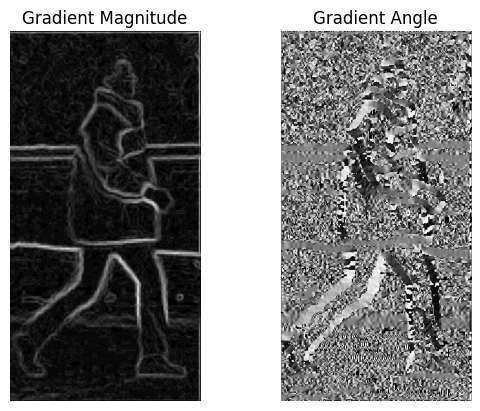

In [29]:
plt.subplot(1, 2, 1)
plt.imshow(magnitude, cmap='gray')
plt.title('Gradient Magnitude')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(angle, cmap='gray')  # Usando 'hsv' para resaltar los colores
plt.title('Gradient Angle')
plt.axis('off')

plt.show()

In [31]:
def build_gradient_block_stack(gradient_magnitude, gradient_angle, block_size):
    # Calcular el tamaño de M y N
    M = gradient_magnitude.shape[0] // (block_size // 2) - 1
    N = gradient_magnitude.shape[1] // (block_size // 2) - 1
    
    # Inicializar los stacks de bloques de magnitud y ángulo
    magnitude_block_stack = np.zeros((M*N, block_size, block_size), dtype=np.float32)
    angle_block_stack = np.zeros((M*N, block_size, block_size), dtype=np.float32)
    
    # Iterar sobre la imagen y construir los stacks de bloques
    index = 0
    for i in range(0, M * (block_size // 2), block_size // 2):
        for j in range(0, N * (block_size // 2), block_size // 2):
            magnitude_block_stack[index] = gradient_magnitude[i:i+block_size, j:j+block_size]
            angle_block_stack[index] = gradient_angle[i:i+block_size, j:j+block_size]
            index += 1
            
    return magnitude_block_stack, angle_block_stack

# Ejemplo de uso
block_size = 4  # Puedes ajustar este valor según lo necesites
magnitude_block_stack, angle_block_stack = build_gradient_block_stack(magnitude, angle, block_size)
